In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Load the data

In [2]:
TRAIN_PATH = './Dataset/Gender/Training'
VALID_PATH = './Dataset/Gender/Validation'
TEST_PATH = './Dataset/Gender/Testing'

In [3]:
IMG_SIZE = (96, 96)
BATCH_SIZE = 64

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_PATH, shuffle=True, image_size=IMG_SIZE, batch_size = BATCH_SIZE)
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(VALID_PATH, shuffle=True, image_size=IMG_SIZE, batch_size = BATCH_SIZE)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(TEST_PATH, shuffle=True, image_size=IMG_SIZE, batch_size = BATCH_SIZE)

Found 10000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [4]:
print('Train batches:', tf.data.experimental.cardinality(train_dataset))
print('Test batches:', tf.data.experimental.cardinality(test_dataset))
print('Valid batches:', tf.data.experimental.cardinality(valid_dataset))

Train batches: tf.Tensor(157, shape=(), dtype=int64)
Test batches: tf.Tensor(16, shape=(), dtype=int64)
Valid batches: tf.Tensor(16, shape=(), dtype=int64)


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

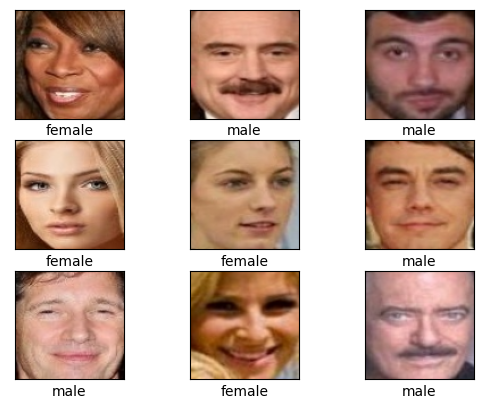

In [4]:
classes = ['female', 'male']

for image, label in train_dataset.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[i] / 255)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(classes[label[i]])

plt.show()

## Data augmentation

In [17]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomZoom, RandomRotation

data_augmentation = tf.keras.Sequential([
  RandomFlip('horizontal'),
  RandomZoom(0.1)
])

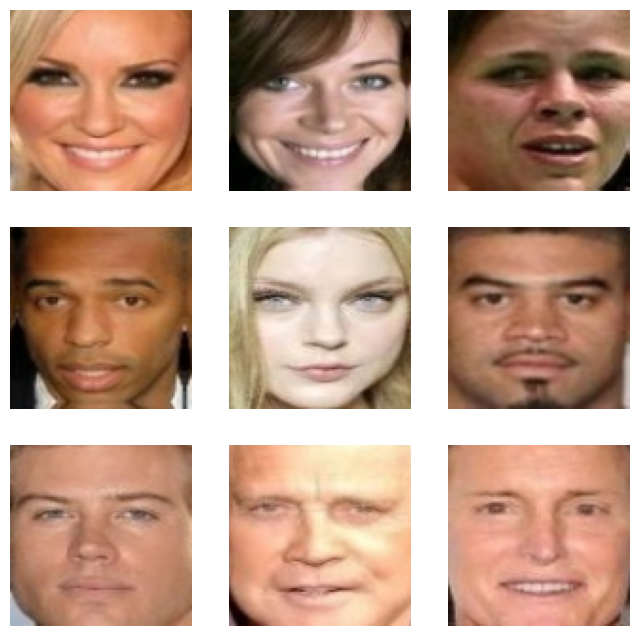

In [18]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(8, 8))
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(image[i], 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

plt.show()

## Self-building model

In [19]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = tf.keras.Sequential([
  Input(shape=(IMG_SIZE + (3,))),

  Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(pool_size=2, strides=2),

  Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(pool_size=2, strides=2),

  Conv2D(64, kernel_size=3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(pool_size=2, strides=2),

  Conv2D(128, kernel_size=3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(pool_size=2, strides=2),

  Conv2D(256, kernel_size=3, padding='same', activation='relu'),
  BatchNormalization(),
  MaxPooling2D(pool_size=2, strides=2),
  Dropout(0.2),

  Flatten(),

  Dense(256, activation='relu'),
  Dropout(0.2),
  
  Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)       

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

### Training and evaluation

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-5, mode='auto', restore_best_weights=True, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('gender_ckpt.h5', monitor='val_loss', save_weights_only=True)

history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset, callbacks=[early_stopping, checkpoint])

Epoch 1/10
157/157 [==============================] - 11s 47ms/step - loss: 0.5992 - accuracy: 0.7320 - val_loss: 0.4088 - val_accuracy: 0.8290
Epoch 2/10
157/157 [==============================] - 7s 44ms/step - loss: 0.2538 - accuracy: 0.9031 - val_loss: 0.2689 - val_accuracy: 0.8950
Epoch 3/10
157/157 [==============================] - 7s 43ms/step - loss: 0.1813 - accuracy: 0.9289 - val_loss: 0.2232 - val_accuracy: 0.9150
Epoch 4/10
157/157 [==============================] - 6s 39ms/step - loss: 0.1366 - accuracy: 0.9477 - val_loss: 0.2039 - val_accuracy: 0.9290
Epoch 5/10
157/157 [==============================] - 8s 46ms/step - loss: 0.0975 - accuracy: 0.9656 - val_loss: 0.2155 - val_accuracy: 0.9280
Epoch 6/10
157/157 [==============================] - 9s 52ms/step - loss: 0.0792 - accuracy: 0.9714 - val_loss: 0.1947 - val_accuracy: 0.9340
Epoch 7/10
157/157 [==============================] - 8s 52ms/step - loss: 0.0583 - accuracy: 0.9781 - val_loss: 0.2338 - val_accuracy: 0.927

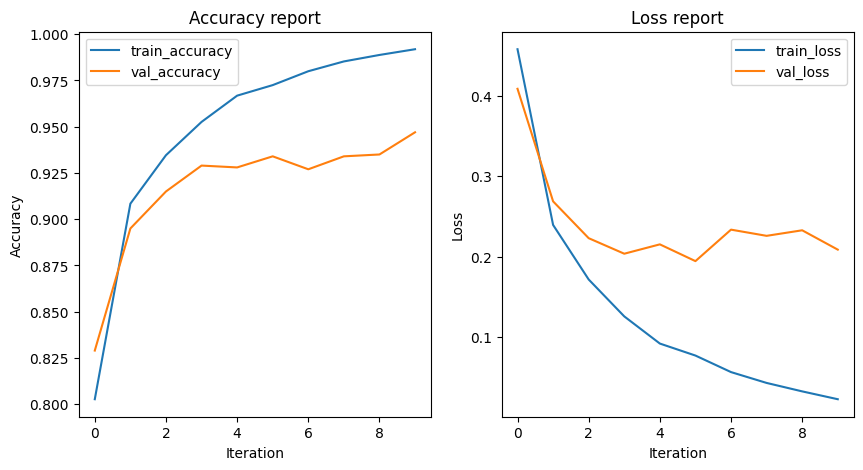

In [22]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title('Accuracy report')
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(122)
plt.title('Loss report')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()


plt.show()

In [24]:
model.load_weights('gender_ckpt.h5')

In [26]:
model.evaluate(test_dataset)


16/16 [==============================] - 1s 27ms/step - loss: 0.1822 - accuracy: 0.9540


[0.18221355974674225, 0.9539999961853027]

In [27]:
model.save('gender_1.h5')

## Load pre-trained model

### Using MobileNetV2

In [28]:
IMG_SHAPE = IMG_SIZE + (3,)

preprocess_image = tf.keras.applications.mobilenet_v2.preprocess_input

base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE, include_top=False, weights='imagenet')

In [29]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout

base_model.trainable = False

inputs = Input(shape=IMG_SHAPE)
preprocessed = preprocess_image(inputs)
features = base_model(preprocessed, training=False)
features = GlobalAveragePooling2D()(features)
features = Dropout(0.2)(features)
fc = Dense(256, activation='relu')(features)
features = Dropout(0.2)(fc)
fc = Dense(128, activation='relu')(features)
features = Dropout(0.2)(fc)
outputs = Dense(1, activation='sigmoid')(features)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               327936

In [30]:
base_lr = 1e-4

optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-5, mode='auto', restore_best_weights=True, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('gender_ckpt.h5', monitor='val_loss', save_weights_only=True)

base_epoch = 10

history = model.fit(train_dataset, epochs=base_epoch, validation_data=valid_dataset, callbacks=[early_stopping, checkpoint])

Epoch 1/10
157/157 [==============================] - 13s 59ms/step - loss: 0.6600 - accuracy: 0.6446 - val_loss: 0.3345 - val_accuracy: 0.8650
Epoch 2/10
157/157 [==============================] - 7s 44ms/step - loss: 0.3731 - accuracy: 0.8397 - val_loss: 0.2860 - val_accuracy: 0.8860
Epoch 3/10
157/157 [==============================] - 9s 55ms/step - loss: 0.3304 - accuracy: 0.8634 - val_loss: 0.2613 - val_accuracy: 0.9000
Epoch 4/10
157/157 [==============================] - 7s 45ms/step - loss: 0.3031 - accuracy: 0.8745 - val_loss: 0.2448 - val_accuracy: 0.9020
Epoch 5/10
157/157 [==============================] - 7s 40ms/step - loss: 0.2895 - accuracy: 0.8805 - val_loss: 0.2314 - val_accuracy: 0.9120
Epoch 6/10
157/157 [==============================] - 7s 43ms/step - loss: 0.2792 - accuracy: 0.8831 - val_loss: 0.2279 - val_accuracy: 0.9130
Epoch 7/10
157/157 [==============================] - 9s 55ms/step - loss: 0.2731 - accuracy: 0.8910 - val_loss: 0.2255 - val_accuracy: 0.909

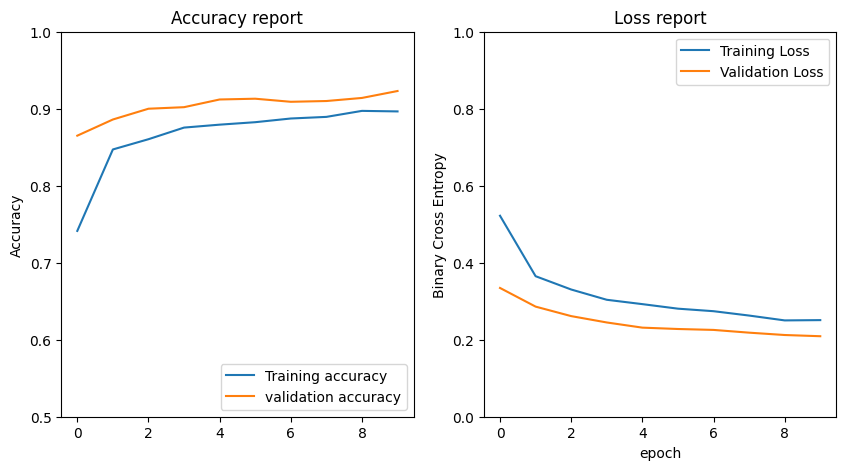

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.0])
plt.title('Accuracy report')

plt.subplot(122)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Loss report')
plt.xlabel('epoch')

plt.show()

In [33]:
model.evaluate(test_dataset)


16/16 [==============================] - 1s 31ms/step - loss: 0.2325 - accuracy: 0.9090


[0.23250995576381683, 0.9089999794960022]

Fine Tuning

In [34]:
base_model.trainable = True

print('Number of layers in base model:', len(base_model.layers))

Number of layers in base model: 154


In [35]:
fine_tune_from = 114

for layer in base_model.layers[:fine_tune_from]:
  layer.trainable = False

In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr / 10)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [37]:
total_epoch = base_epoch + 10

history_fine = model.fit(train_dataset, epochs=total_epoch, initial_epoch=base_epoch, validation_data=valid_dataset, callbacks=[early_stopping, checkpoint])

Epoch 11/20
157/157 [==============================] - 12s 56ms/step - loss: 0.2265 - accuracy: 0.9099 - val_loss: 0.1780 - val_accuracy: 0.9320
Epoch 12/20
157/157 [==============================] - 8s 50ms/step - loss: 0.1798 - accuracy: 0.9311 - val_loss: 0.1805 - val_accuracy: 0.9320
Epoch 13/20
157/157 [==============================] - 8s 50ms/step - loss: 0.1531 - accuracy: 0.9439 - val_loss: 0.1649 - val_accuracy: 0.9320
Epoch 14/20
157/157 [==============================] - 8s 50ms/step - loss: 0.1431 - accuracy: 0.9403 - val_loss: 0.1547 - val_accuracy: 0.9400
Epoch 15/20
157/157 [==============================] - 8s 51ms/step - loss: 0.1138 - accuracy: 0.9585 - val_loss: 0.1539 - val_accuracy: 0.9480
Epoch 16/20
157/157 [==============================] - 8s 51ms/step - loss: 0.1047 - accuracy: 0.9638 - val_loss: 0.1590 - val_accuracy: 0.9420
Epoch 17/20
157/157 [==============================] - 9s 53ms/step - loss: 0.0917 - accuracy: 0.9663 - val_loss: 0.1713 - val_accuracy

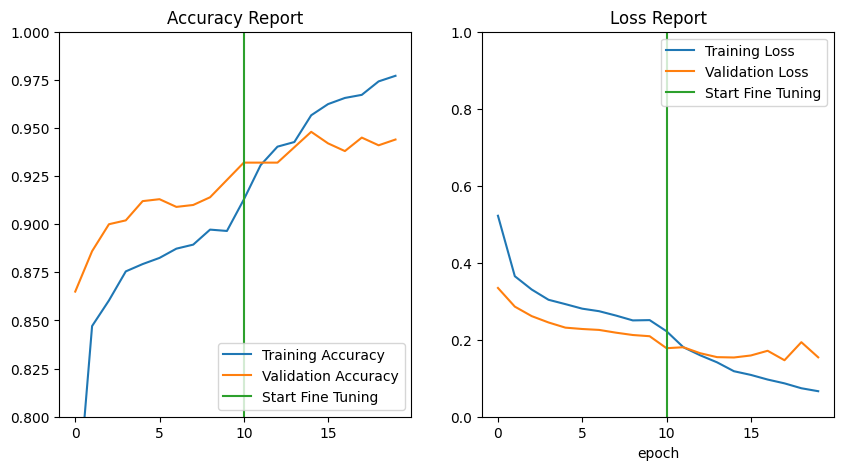

In [38]:
new_acc = acc + history_fine.history['accuracy']
new_val_acc = val_acc + history_fine.history['val_accuracy']

new_loss = loss + history_fine.history['loss']
new_val_loss = val_loss + history_fine.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(new_acc, label='Training Accuracy')
plt.plot(new_val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([base_epoch,base_epoch], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Accuracy Report')

plt.subplot(122)
plt.plot(new_loss, label='Training Loss')
plt.plot(new_val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([base_epoch,base_epoch], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Loss Report')
plt.xlabel('epoch')

plt.show()

In [40]:
model.load_weights('gender_ckpt.h5')

In [41]:
model.evaluate(test_dataset)

16/16 [==============================] - 1s 40ms/step - loss: 0.1859 - accuracy: 0.9400


[0.18591536581516266, 0.9399999976158142]

In [44]:
model.save('gender_2.h5')

### Using ResNes50

In [45]:
IMG_SHAPE = IMG_SIZE + (3,)

preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

base_model = tf.keras.applications.ResNet50V2(input_shape = IMG_SHAPE, include_top=False, weights='imagenet')

base_model.trainable = False

In [46]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout

base_model.trainable = False

inputs = Input(shape=IMG_SHAPE)
preprocessed = preprocess_input(inputs)
features = base_model(preprocessed, training=False)
features = GlobalAveragePooling2D()(features)
features = Dropout(0.2)(features)
fc = Dense(256, activation='relu')(features)
features = Dropout(0.2)(fc)
fc = Dense(128, activation='relu')(features)
features = Dropout(0.2)(fc)
outputs = Dense(1, activation='sigmoid')(features)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 96, 96, 3)         0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 3, 3, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               5245

In [47]:
base_lr = 1e-4

optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [49]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-5, mode='auto', restore_best_weights=True, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('gender_ckpt.h5', monitor='val_loss', verbore=1, save_best_only=True)

initial_epoch = 10

history = model.fit(train_dataset, epochs=initial_epoch, validation_data=valid_dataset, callbacks=[early_stopping, checkpoint])

Epoch 1/10
157/157 [==============================] - 15s 75ms/step - loss: 0.5312 - accuracy: 0.7630 - val_loss: 0.3297 - val_accuracy: 0.8690
Epoch 2/10
157/157 [==============================] - 10s 59ms/step - loss: 0.3858 - accuracy: 0.8339 - val_loss: 0.3134 - val_accuracy: 0.8800
Epoch 3/10
157/157 [==============================] - 9s 55ms/step - loss: 0.3376 - accuracy: 0.8601 - val_loss: 0.2977 - val_accuracy: 0.8790
Epoch 4/10
157/157 [==============================] - 9s 58ms/step - loss: 0.3304 - accuracy: 0.8602 - val_loss: 0.2778 - val_accuracy: 0.8940
Epoch 5/10
157/157 [==============================] - 9s 54ms/step - loss: 0.3006 - accuracy: 0.8726 - val_loss: 0.2752 - val_accuracy: 0.8890
Epoch 6/10
157/157 [==============================] - 9s 54ms/step - loss: 0.2930 - accuracy: 0.8804 - val_loss: 0.2714 - val_accuracy: 0.8920
Epoch 7/10
157/157 [==============================] - 9s 54ms/step - loss: 0.2807 - accuracy: 0.8844 - val_loss: 0.2647 - val_accuracy: 0.89

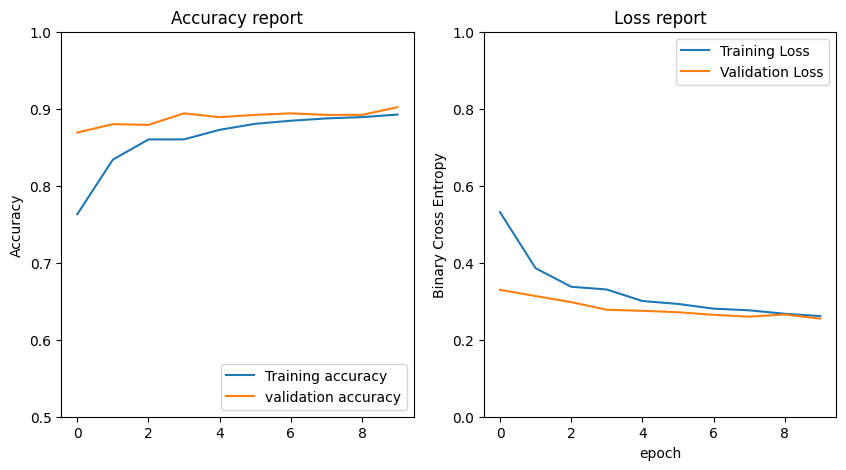

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.0])
plt.title('Accuracy report')

plt.subplot(122)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Loss report')
plt.xlabel('epoch')

plt.show()

In [51]:
model.evaluate(test_dataset)

16/16 [==============================] - 1s 56ms/step - loss: 0.2265 - accuracy: 0.9090


[0.22652842104434967, 0.9089999794960022]

In [52]:
base_model.trainable = True

print('Number of layers in base model:', len(base_model.layers))

Number of layers in base model: 190


In [53]:
fine_tune_at = 140

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [54]:
optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr / 10)
model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [55]:
total_epoch = initial_epoch + 10

history_fine = model.fit(train_dataset, epochs=total_epoch, initial_epoch=initial_epoch, validation_data=valid_dataset, callbacks=[early_stopping, checkpoint])

Epoch 11/20
157/157 [==============================] - 19s 94ms/step - loss: 0.2299 - accuracy: 0.9064 - val_loss: 0.1831 - val_accuracy: 0.9390
Epoch 12/20
157/157 [==============================] - 14s 86ms/step - loss: 0.1323 - accuracy: 0.9525 - val_loss: 0.1787 - val_accuracy: 0.9400
Epoch 13/20
157/157 [==============================] - 14s 88ms/step - loss: 0.0849 - accuracy: 0.9701 - val_loss: 0.1818 - val_accuracy: 0.9420
Epoch 14/20
157/157 [==============================] - 14s 87ms/step - loss: 0.0524 - accuracy: 0.9841 - val_loss: 0.1998 - val_accuracy: 0.9360
Epoch 15/20
157/157 [==============================] - 14s 87ms/step - loss: 0.0332 - accuracy: 0.9910 - val_loss: 0.2119 - val_accuracy: 0.9470
Epoch 16/20
157/157 [==============================] - 14s 88ms/step - loss: 0.0174 - accuracy: 0.9948 - val_loss: 0.2606 - val_accuracy: 0.9470
Epoch 17/20
157/157 [==============================] - 14s 89ms/step - loss: 0.0083 - accuracy: 0.9972 - val_loss: 0.2660 - val_ac

In [59]:
model.evaluate(test_dataset)

16/16 [==============================] - 1s 48ms/step - loss: 0.1681 - accuracy: 0.9390


[0.1681062877178192, 0.9390000104904175]

In [58]:
model.load_weights('gender_ckpt.h5')

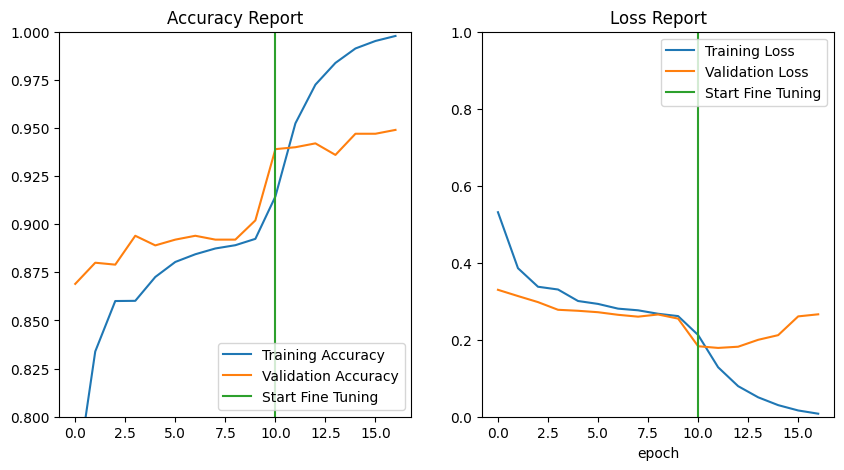

In [57]:
new_acc = acc + history_fine.history['accuracy']
new_val_acc = val_acc + history_fine.history['val_accuracy']

new_loss = loss + history_fine.history['loss']
new_val_loss = val_loss + history_fine.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(new_acc, label='Training Accuracy')
plt.plot(new_val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([base_epoch,base_epoch], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Accuracy Report')

plt.subplot(122)
plt.plot(new_loss, label='Training Loss')
plt.plot(new_val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([base_epoch,base_epoch], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Loss Report')
plt.xlabel('epoch')

plt.show()

In [60]:
model.save('gender_3.h5')